In [11]:
import numpy as np
import os
from matplotlib import pyplot as plt
import shutil
import cv2
import random

In [12]:
import scipy
import skimage
from skimage.util.shape import view_as_windows
from scipy.ndimage.filters import gaussian_filter

import keras
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Concatenate, Subtract, Dropout, BatchNormalization
from keras.models import Model
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.models import load_model
import time
from keras import backend as K
K.set_image_data_format('channels_first')

from fr_utils import *
from inception_blocks_v2 import *



Using TensorFlow backend.


In [2]:
os.makedirs('./data')

### Downloading and Extracting the Data

In [4]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -P data/

--2019-05-14 22:58:59--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘data/lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  35.5MB/s    in 7.0s    

2019-05-14 22:59:06 (24.7 MB/s) - ‘data/lfw.tgz’ saved [180566744/180566744]



In [ ]:
!tar -zxvf data/lfw.tgz -C data/

### Let's look at some of the images

(250, 250, 3)


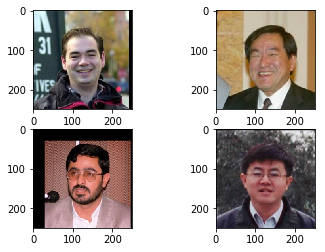

In [168]:
image_data=[]
transformed_list=os.listdir('data/lfw')
for i in range(4):
    folder=np.random.choice(transformed_list)
    img=cv2.imread(os.path.join('data/lfw',folder,folder+'_0001.jpg'))
    image_data.append(img[...,::-1])

_,ax= plt.subplots(2,2)
ax[0,0].imshow(image_data[0])
ax[0,1].imshow(image_data[1])
ax[1,0].imshow(image_data[2])
ax[1,1].imshow(image_data[3])

print(image_data[0].shape)
  

### To extract good face features, we need to transform the images so that face occupies more space in the image.
#### This can be done by Multi Task CNN. Source: https://github.com/sainimohit23/FaceNet-Real-Time-face-recognition

In [ ]:
#Transforming the images
# Note: this script will only work with numpy version 1.16.1
! python FaceNet-Real-Time-face-recognition/align_dataset_mtcnn.py data/lfw/ data/aligned_faces

#### Let's see how the images look after Transformation

(96, 96, 3)


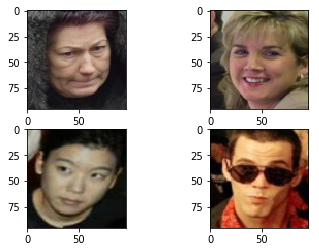

In [169]:
image_data=[]
transformed_list=os.listdir('data/aligned_faces/')
for i in range(4):
    folder=np.random.choice(transformed_list)
    img=cv2.imread(os.path.join('data/aligned_faces',folder,folder+'_0001.png'))
    image_data.append(img[...,::-1])

_,ax= plt.subplots(2,2)
ax[0,0].imshow(image_data[0])
ax[0,1].imshow(image_data[1])
ax[1,0].imshow(image_data[2])
ax[1,1].imshow(image_data[3])

print(image_data[0].shape)
  

### Since we have only 1608 unique people with multiple photographs, we might want to increase the dataset size for better perfomance
#### As our aim is to find face similiarity, all these techniques, which preserve the general face features, can be used

In [170]:
## Data Augmentations

##Mirror Image
def flip_hor(img):
    return np.flip(img,1)

##Tilt the image at an angle
def rotate(img,angle):
    img=skimage.transform.rotate(img,angle, mode='reflect')*255
    img=img.astype(int)
    return img

##Generate random patch from an image
def random_crop(img):
    x=img.shape[1]/5
    l,r,t,b=np.random.randint(0,x),np.random.randint(0,x),np.random.randint(0,x),np.random.randint(0,x)
    h,w=img.shape[:-1]
    img=img[t:h-b,l:w-r,:]
    img= cv2.resize(img.astype(np.float), dsize=(96,96))
    return img.astype(int)

## Generate blurred version of the image  
def blur_image(img):
    return cv2.blur(img,(3,3))
  



In [171]:
## Function to randomly apply augmentation techniques
## For an image, we want to use each technique , more often than not. Boolean sampling is done accordingly
def AugmentImage(img):
    if np.random.randint(0,3):
        img=flip_hor(img)
    
    if np.random.randint(0,3):
        img= rotate(img,15)

    if np.random.randint(0,3):
        img=random_crop(img)

    if np.random.randint(0,3):
        img=blur_image(img)
    
    return img

### Let's have a look at couple of images to see how augmented images look like

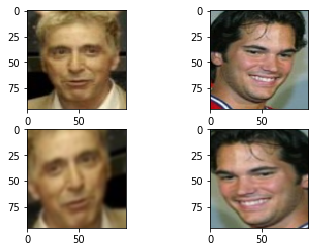

In [172]:
image_data=[]
image_data_augmented=[]
transformed_list=os.listdir('data/aligned_faces/')
for i in range(2):
    folder=np.random.choice(transformed_list)
    img=cv2.imread(os.path.join('data/aligned_faces',folder,folder+'_0001.png'))
    image_data.append(img[...,::-1])
    image_data_augmented.append(AugmentImage(img[...,::-1]))

_,ax= plt.subplots(2,2)
ax[0,0].imshow(image_data[0])
ax[0,1].imshow(image_data[1])
ax[1,0].imshow(image_data_augmented[0])
ax[1,1].imshow(image_data_augmented[1])
  

In [173]:
DATA_PATH='data/aligned_faces/'
MULTI_DIR_PATH='data/image_directory/multi/'
SINGLE_DIR_PATH='data/image_directory/single/'



#### Segregating the images of persons into two categories: Single and Multi, based upon the number of images per person

In [ ]:
for name in DIR_DATA:
    folder=os.path.join(DATA_PATH,name)
    if os.path.isdir(folder):
        if len(os.listdir(folder))>1:
            shutil.copytree(folder,MULTI_DIR_PATH+name)
    else:
        if len(os.listdir(folder))!=0:
            shutil.copytree(folder,SINGLE_DIR_PATH+name)
    
    

In [177]:
## Creating a Train-Validation Split

DIR_DATA=os.listdir(DATA_PATH)
train_split=0.8
DIRS_SINGLE_ALL=os.listdir(SINGLE_DIR_PATH)
DIRS_MULTI_ALL=os.listdir(MULTI_DIR_PATH)
random.shuffle(DIRS_SINGLE_ALL)
random.shuffle(DIRS_MULTI_ALL)
DIRS_SINGLE_TRAINING=DIRS_SINGLE[:int(train_split*len(DIRS_SINGLE_ALL))]
DIRS_SINGLE_VAL=DIRS_SINGLE[int(train_split*len(DIRS_SINGLE_ALL)):]

DIRS_MULTI_TRAINING=DIRS_MULTI[:int(train_split*len(DIRS_MULTI_ALL))]
DIRS_MULTI_VAL=DIRS_MULTI[int(train_split*len(DIRS_MULTI_ALL)):]

LEN_SINGLE_TRAINING=len(DIRS_SINGLE_TRAINING)
LEN_MULTI_TRAINING=len(DIRS_MULTI_TRAINING)
LEN_SINGLE_VAL=len(DIRS_SINGLE_VAL)
LEN_MULTI_VAL=len(DIRS_MULTI_VAL)


### Batch generator of images and labels for training
Will generate a batch directly from the disk<br>
Will generate equal number of positive and negative samples<br>
Batch size and amount of augmentation data needed, can be passed as arguments<br>



In [225]:
#### Note: the pretrained model might fail to load in version of Keras other than 2.1.16

In [178]:
#aug_factor , number of augmented images as a fraction of similar faces in a batch
#To disable augmentation, set aug_factor=0
def images_generator(DIRS_SINGLE,DIRS_MULTI,LEN_SINGLE,LEN_MULTI,batch_size = 64, aug_factor=0.2):
    while True:
        im1,im2,labels=[],[],[]
        #generating batch images for similar faces
        for i in range(batch_size//2):

            if np.random.rand()<aug_factor: #augmented pair of images
                random_a=np.random.randint(0,LEN_SINGLE)
                images_temp=os.listdir(os.path.join(SINGLE_DIR_PATH,DIRS_SINGLE[random_a]))
                anc_img=cv2.imread(os.path.join(SINGLE_DIR_PATH,DIRS_SINGLE[random_a],images_temp[0]))
                img = anc_img[...,::-1]
                img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
                im1.append(img)

                img=AugmentImage(anc_img)
                img = img[...,::-1]
                img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
                im2.append(img)

            else: #non augmented pair of images
                random_a=np.random.randint(0,LEN_MULTI)
                images_temp=os.listdir(os.path.join(MULTI_DIR_PATH,DIRS_MULTI[random_a]))
                anc_img=cv2.imread(os.path.join(MULTI_DIR_PATH,DIRS_MULTI[random_a],images_temp[0]))
                img = anc_img[...,::-1]
                img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
                im1.append(img)


                img=cv2.imread(os.path.join(MULTI_DIR_PATH,DIRS_MULTI[random_a],np.random.choice(images_temp[1:])))
                img = img[...,::-1]
                img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
                im2.append(img)
            labels.append(0)
        
        for i in range(batch_size//2): ##generating pair of dissimilar faces
            random_a=np.random.randint(0,LEN_SINGLE)
            images_temp=os.listdir(os.path.join(SINGLE_DIR_PATH,DIRS_SINGLE[random_a]))
            anc_img=cv2.imread(os.path.join(SINGLE_DIR_PATH,DIRS_SINGLE[random_a],images_temp[0]))
            img = anc_img[...,::-1]
            img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
            im1.append(img)

            random_b=np.random.randint(0,LEN_MULTI+LEN_SINGLE)
            neg_folder_path= lambda x: MULTI_DIR_PATH if x<LEN_MULTI else SINGLE_DIR_PATH
            neg_folder_dir= lambda x: DIRS_MULTI if x<LEN_MULTI else DIRS_SINGLE
            neg_folder_p=neg_folder_path(random_b)
            neg_images=os.listdir(os.path.join(neg_folder_p,(DIRS_MULTI+DIRS_SINGLE)[random_b]))
            neg_image_path=os.path.join(neg_folder_p, (DIRS_MULTI+DIRS_SINGLE)[random_b], np.random.choice(neg_images))

            img=cv2.imread(neg_image_path)
            img = img[...,::-1]
            img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
            im2.append(img)
            labels.append(1)
        

        im1,im2,labels=np.array(im1),np.array(im2),np.array(labels)

        x_data = {'t1': im1,
                't2': im2,
                }

        yield (x_data, labels)

In [179]:
## switching to 'channels last' mode to plot the image returned from generator
def deconvert(img):
    return np.transpose(img,(1,2,0))

In [180]:
gen_img_training=images_generator(DIRS_SINGLE_TRAINING,DIRS_MULTI_TRAINING,LEN_SINGLE_TRAINING,LEN_MULTI_TRAINING)
gen_img_val=images_generator(DIRS_SINGLE_VAL,DIRS_MULTI_VAL,LEN_SINGLE_VAL,LEN_MULTI_VAL)

In [181]:
picset['t1'].shape

(64, 3, 96, 96)

### Let's have a look at some of the images returned by the generator
#### Similar Faces

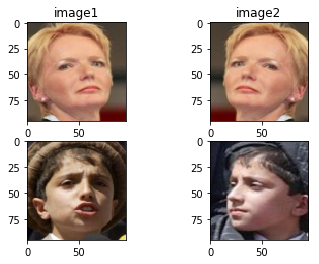

In [185]:
picset,labels=next(gen_img_training)
fig,ax=plt.subplots(2,2)
for i,el in enumerate(range(2)):
    ax[i,0].imshow(deconvert(picset['t1'][el]))
    ax[i,1].imshow(deconvert(picset['t2'][el]))
    if i==0:
        ax[i,0].set_title('image1')
        ax[i,1].set_title('image2')

#### Dissimilar Faces

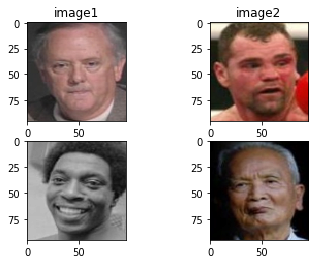

In [186]:
picset,labels=next(gen_img_training)
fig,ax=plt.subplots(2,2)
for i,el in enumerate(range(33,35)):
    ax[i,0].imshow(deconvert(picset['t1'][el]))
    ax[i,1].imshow(deconvert(picset['t2'][el]))
    if i==0:
        ax[i,0].set_title('image1')
        ax[i,1].set_title('image2')

## Model

Dowloaded the pretrained facenet model. 
Source: https://github.com/sainimohit23/FaceNet-Real-Time-face-recognition

Facenet input: (channels,96,96)<br>
Facenet output: A face embedding of length 128
<br>
We'll derive generate these embedddings and tailor a model on top of it, for our problem statement of face similiarity


#### Loading Pretrained model

In [226]:
FRmodel.set_weights(keep_weights)

In [155]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))
load_weights_from_FaceNet(FRmodel)

#### Pre-trained model has total 155 layers including multiple inception blocks

In [125]:
FRmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
zero_padding2d_70 (ZeroPadding2 (None, 3, 102, 102)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_70[0][0]          
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Building a secondary model on top of Facenet

In [227]:
def new_model(layers_trainable, is_initialize=False):
    
    ### Keep all the layers frozen, when intializing
    if is_initialize:
        for layer in FRmodel.layers:
            layer.trainable  =  False
    else:
        for layer in FRmodel.layers[-layers_trainable:]:
            layer.trainable  =  True

    input_shape=(3,96, 96)
    test_image1 = Input(shape=input_shape, name = 't1')
    test_image2 = Input(shape=input_shape, name = 't2')

    embedding_1=FRmodel(test_image1)
    embedding_2=FRmodel(test_image2)

    Difference=Subtract()([embedding_1,embedding_2])
    dropout1=Dropout(0.3)(Difference)
    fc1=Dense(64, activation='relu')(dropout1)
    dropout2=Dropout(0.4)(fc1)
    bn1=BatchNormalization()(dropout2)
    final=Dense(1,activation='sigmoid')(bn1)

    newmodel=Model([test_image1,test_image2], final)
    

    
    return newmodel

        

#### Let's train only newly added layers first. 

In [205]:

prediction_model=new_model(layers_trainable=0,is_initialize=True)

In [206]:
prediction_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
t1 (InputLayer)                 (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
t2 (InputLayer)                 (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
FaceRecoModel (Model)           (None, 128)          3743280     t1[0][0]                         
                                                                 t2[0][0]                         
__________________________________________________________________________________________________
subtract_12 (Subtract)          (None, 128)          0           FaceRecoModel[7][0]              
          

In [211]:
##Callbacks
early_stopping=EarlyStopping(monitor='val_acc', patience=4, min_delta=0.001)
checkpoint=ModelCheckpoint(filepath='./checkpoints/model.{epoch:02d}.hd5',save_best_only=True)

In [208]:
prediction_model.compile(optimizer = keras.optimizers.Adam(lr=5e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [212]:
n_epochs=20
n_steps_per_epoch=40
n_val_steps=5

In [213]:
history1=prediction_model.fit_generator(gen_img_training, epochs=n_epochs,steps_per_epoch=n_steps_per_epoch,callbacks=[early_stopping,checkpoint], validation_data=gen_img_val, validation_steps=n_val_steps)

Epoch 1/20
40/40 [==============================] - 4s 102ms/step - loss: 0.5892 - acc: 0.6859 - val_loss: 0.8014 - val_acc: 0.5344
Epoch 2/20
40/40 [==============================] - 4s 89ms/step - loss: 0.5739 - acc: 0.6910 - val_loss: 0.8022 - val_acc: 0.5125
Epoch 3/20
40/40 [==============================] - 4s 89ms/step - loss: 0.5787 - acc: 0.7059 - val_loss: 0.8042 - val_acc: 0.5312
Epoch 4/20
40/40 [==============================] - 4s 88ms/step - loss: 0.5829 - acc: 0.6941 - val_loss: 0.7833 - val_acc: 0.5219
Epoch 5/20
40/40 [==============================] - 4s 90ms/step - loss: 0.6002 - acc: 0.6711 - val_loss: 0.7817 - val_acc: 0.5312


#### Training loss is not improving. Let's try unfreezing some more layers

In [230]:
##Opening up inception layer for training
prediction_model=new_model(layers_trainable=25)
prediction_model.compile(optimizer = keras.optimizers.Adam(lr=5e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [219]:
history2=prediction_model.fit_generator(gen_img_training, epochs=n_epochs,steps_per_epoch=n_steps_per_epoch,callbacks=[checkpoint], validation_data=gen_img_val, validation_steps=n_val_steps)

Epoch 1/20
40/40 [==============================] - 24s 608ms/step - loss: 0.7422 - acc: 0.5758 - val_loss: 0.6536 - val_acc: 0.6250
Epoch 2/20
40/40 [==============================] - 3s 85ms/step - loss: 0.5940 - acc: 0.6801 - val_loss: 0.5910 - val_acc: 0.7031
Epoch 3/20
40/40 [==============================] - 4s 89ms/step - loss: 0.5252 - acc: 0.7375 - val_loss: 0.6501 - val_acc: 0.6344
Epoch 4/20
40/40 [==============================] - 4s 91ms/step - loss: 0.4975 - acc: 0.7582 - val_loss: 0.6828 - val_acc: 0.6031
Epoch 5/20
40/40 [==============================] - 4s 90ms/step - loss: 0.4863 - acc: 0.7766 - val_loss: 0.6147 - val_acc: 0.6687
Epoch 6/20
40/40 [==============================] - 4s 89ms/step - loss: 0.4511 - acc: 0.7902 - val_loss: 0.6269 - val_acc: 0.6250
Epoch 7/20
40/40 [==============================] - 4s 89ms/step - loss: 0.4457 - acc: 0.7883 - val_loss: 0.6608 - val_acc: 0.6500
Epoch 8/20
40/40 [==============================] - 4s 89ms/step - loss: 0.4110 -

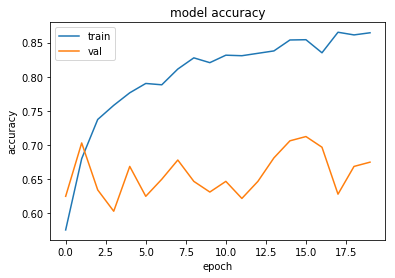

In [221]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model is overfitting
The layers of Facenet have become accessible for training. The layers are cramming up the training input. We might 
need some more experiments on better architectures which can regularize the training.
Avoiding spending time on further experimentation, as accuracy holds lesser weight for this assignment.
As of now, we will end our training iterations here

<b>Val Accuracy : 70.31% <b>